In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.cluster import Decahedron
from tqdm.auto import tqdm

from abtem import *
from ase.io import read
import time
import cupy as cp

In [2]:
def plot_comparison(measurement_1, measurement_2, relative=False, relative_tol=.1, titles=None):
    if titles is None:
        titles = ['', '']
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,3))
    
    def plot_array(array, extent, ax, title):
        im = ax.imshow(array.T, extent=extent, origin='lower')
        fig.colorbar(im, ax=ax)
    
    plot_array(measurement_1.array, measurement_1.calibration_limits[0] + measurement_1.calibration_limits[1], ax=ax1, title=titles[0])
    plot_array(measurement_2.array, measurement_2.calibration_limits[0] + measurement_2.calibration_limits[1], ax=ax2, title=titles[1])
    
    if relative:
        array = (measurement_1.array - measurement_2.array) / measurement_1.array * (measurement_1.array > measurement_1.array.max() * relative_tol) * 100
        plot_array(array, measurement_2.calibration_limits[0] + measurement_2.calibration_limits[1], ax=ax3, title='Relative error [%]')
    else:
        plot_array(measurement_1.array - measurement_2.array, measurement_2.calibration_limits[0] + measurement_2.calibration_limits[1], ax=ax3, title='Absolute error')

# Quantifying interpolation errors in the PRISM algorithm

We look at errors introduced by using interpolation within the PRISM algorithm and compare that to using other approximations.

<AxesSubplot:xlabel='y [Å]', ylabel='z [Å]'>

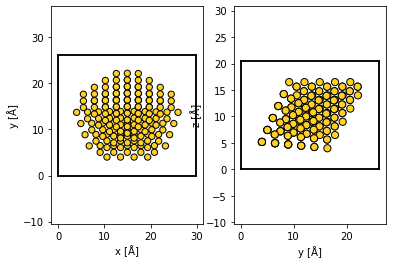

In [3]:
p = 4
atoms = Decahedron('Au', p, 1, 1, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')
atoms.center(vacuum=4)

fig, (ax1, ax2) = plt.subplots(1, 2)

show_atoms(atoms, plane='xy', ax=ax1)
show_atoms(atoms, plane='yz', ax=ax2)

In [12]:
# fp = FrozenPhonons(atoms, sigmas=.07, num_configs=32, seed=1)
potential_thin = Potential(atoms, projection='infinite', parametrization='kirkland', gpts=364, slice_thickness=.5)

S = SMatrix(semiangle_cutoff=20, energy=100e3, interpolation=1)
S.grid.match(potential_thin)

probe = S.get_equivalent_probe()

Increasing the interpolation factor makes the Fourier Space, or angular sampling of correponding diffraction patterns worse. The maximum scattering angle may shift slightly with interpolation, due to floor rounding to the Fourier Space grid.

In [13]:
S.interpolation = 2

print(probe.angular_sampling, probe.sampling, probe.cutoff_scattering_angles)
print(S.angular_sampling, S.sampling, S.cutoff_scattering_angles)

(1.2360081295667504, 1.4166131576039631) (0.08227115673023266, 0.07178234792017675) (149.5569836775768, 149.4526881272181)
(2.472016259133501, 2.8332263152079262) (0.08227115673023266, 0.07178234792017675) (149.55698367757677, 148.7443815484161)


As a first check, we should look at how large the probe is relation to the probe window, the probe should go to zero well within the probe window. However, this should not be taken as proof that the chosen interpolation is reasonable as the probe may increase in size as it propagates.

(<AxesSubplot:title={'center':'Probe from PRISM with interpolation=2'}, xlabel='x [Å]'>,
 <matplotlib.lines.Line2D at 0x2af224b4c10>)

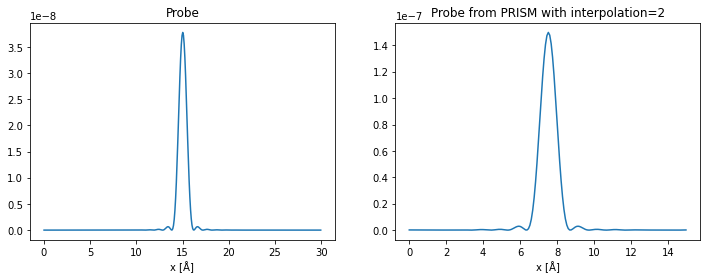

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
probe.profile().show(ax=ax1, title='Probe');
S.profile().show(ax=ax2, title='Probe from PRISM with interpolation=2')

In [15]:
detector = AnnularDetector(50, 140)
gridscan = GridScan((0,0), potential_thin.extent, sampling=probe.ctf.nyquist_sampling*.9)

## No interpolation
We first demonstrate that PRISM and multislice are exactly identical, to within floating point errors, when there is no interpolation.

In [16]:
%%time
S.interpolation = 1
image_prism_thin = S.scan(gridscan, detector, potential_thin)

Potential:   0%|          | 0/41 [00:00<?, ?it/s]

Multislice:   0%|          | 0/729 [00:00<?, ?it/s]

Scan:   0%|          | 0/4536 [00:00<?, ?it/s]

Wall time: 33.6 s


In [19]:
%%time
image_multislice = probe.scan(gridscan, detector, potential_thin, max_batch=300)

Potential:   0%|          | 0/41 [00:00<?, ?it/s]

Scan:   0%|          | 0/4536 [00:00<?, ?it/s]

Wall time: 2min 27s


We show the absolute differences below.

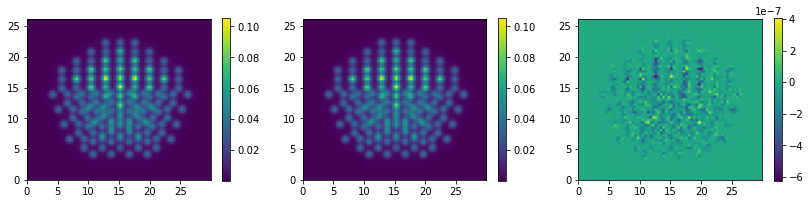

In [22]:
plot_comparison(image_prism_thin, image_multislice, relative=False)

# 

## Two-fold interpolation
We perform the same simulation with two-fold interpolation.

In [20]:
%%time
S.interpolation = 2
image_prism_interp = S.scan(gridscan, detector, potential_thin)

Potential:   0%|          | 0/41 [00:00<?, ?it/s]

Multislice:   0%|          | 0/183 [00:00<?, ?it/s]

Scan:   0%|          | 0/4536 [00:00<?, ?it/s]

Wall time: 7.88 s


We quantify the relative error using the plot below. To avoid dividing by very small numbers when calculating relative differences we set a tolerance at 20 % of the absolute value.

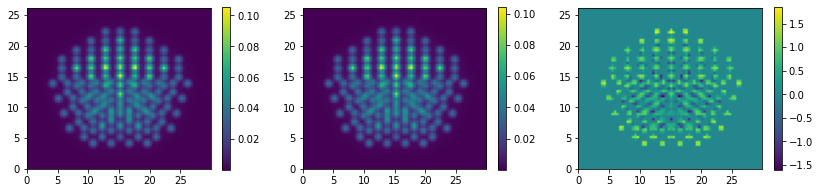

In [23]:
plot_comparison(image_prism_thin, image_prism_interp, relative=True, relative_tol=.2)

## Slice thickness
As a comparison we look at the error introduced by increasing the slice thickness. We double the slice thickness to 1 Å and disable the interpolation.

In [24]:
%%time
# fp = FrozenPhonons(atoms, sigmas=.07, num_configs=32, seed=1)
potential_thick = Potential(atoms, projection='infinite', parametrization='kirkland', gpts=364, device='gpu', slice_thickness=1)

S.interpolation = 1
image_prism_thick = S.scan(gridscan, detector, potential_thick)

Potential:   0%|          | 0/21 [00:00<?, ?it/s]

Multislice:   0%|          | 0/729 [00:00<?, ?it/s]

Scan:   0%|          | 0/4536 [00:00<?, ?it/s]

Wall time: 17.4 s


As shown below, the error is in this case larger, hence we should typically look to using interpolation rather than thicker slices, unless the lateral extent of the sample is too small to use interpolation. It should be noted that the relative errors due to increasing slice thickness generally decreases when using frozen phonons, since the random displacements tends to cancel out unfortunate atomic alignments with the slices.

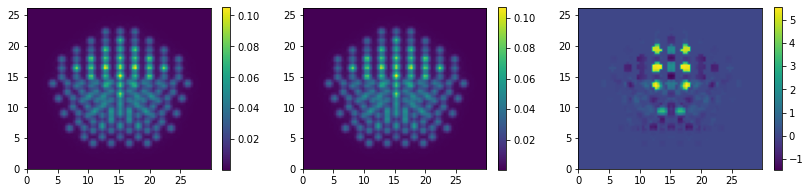

In [25]:
plot_comparison(image_prism_thin, image_prism_thick, relative=True, relative_tol=.2)